<a href="https://colab.research.google.com/github/sudhirslab/aiml-hotspot/blob/main/TimeSeries_Stock_Price_Prediction_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# First, install the necessary libraries
!pip install pandas numpy matplotlib scikit-learn tensorflow yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 10.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 3.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=07c9636372a4c060deca1781ccb8f803a6c73f4c0f5ae4651a0a60086d7cfcbb
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download Historical Stock Data

# Download historical stock data for AAPL (Apple)
stock_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')

# Display the first few rows of the data
stock_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2010-01-04,6.447412,7.643214,7.660714,7.585000,7.622500,493729600
2010-01-05,6.458558,7.656429,7.699643,7.616071,7.664286,601904800
2010-01-06,6.355828,7.534643,7.686786,7.526786,7.656429,552160000
2010-01-07,6.344077,7.520714,7.571429,7.466071,7.562500,477131200
2010-01-08,6.386256,7.570714,7.571429,7.466429,7.510714,447610800


In [ ]:
# Process Data

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Fill missing values using forward fill
stock_data.fillna(method='ffill', inplace=True)

# Use only the 'Close' price for prediction
data = stock_data[['Close']]

# Normalize the data using Min-Max scaling (range [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets (80-20 split)
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Function to create sequences of data for LSTM model
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # past 60 days
        y.append(data[i, 0])  # next day
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape X_train and X_test to match LSTM input shape (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


/tmp/ipykernel_30/1814999061.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [ ]:
# Build LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 7.0722e-04 - val_loss: 0.0033
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.5459e-04 - val_loss: 0.0012
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 4.5622e-04 - val_loss: 0.0012
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.9873e-04 - val_loss: 9.6792e-04
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 4.6725e-04 - val_loss: 0.0013
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 4.6353e-04 - val_loss: 9.9869e-04
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.3296e-04 - val_loss: 0.0018
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.1339e-04 - val_loss: 7.9401e-04
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.5973e-04 - val_loss: 7.7764e-04


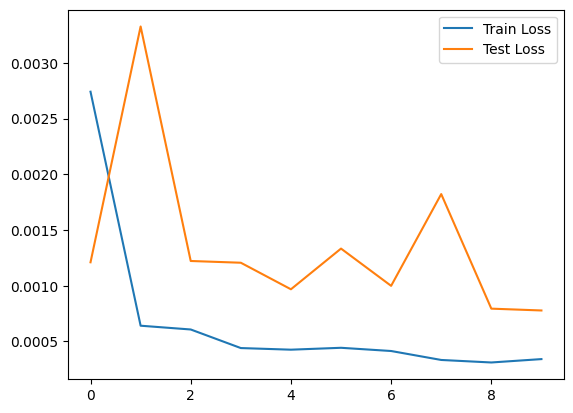

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


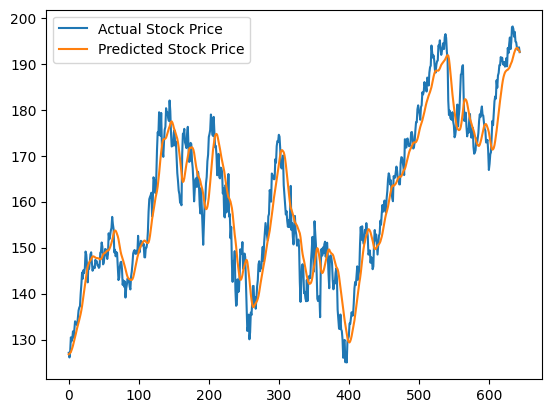

In [ ]:
# Predict stock prices using the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and true values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.plot(y_test_actual, label='Actual Stock Price')
plt.plot(predictions, label='Predicted Stock Price')
plt.legend()
plt.show()


In [ ]:
# EVALUATE MODEL
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 4.36653622176296
Root Mean Squared Error (RMSE): 5.333266815623951


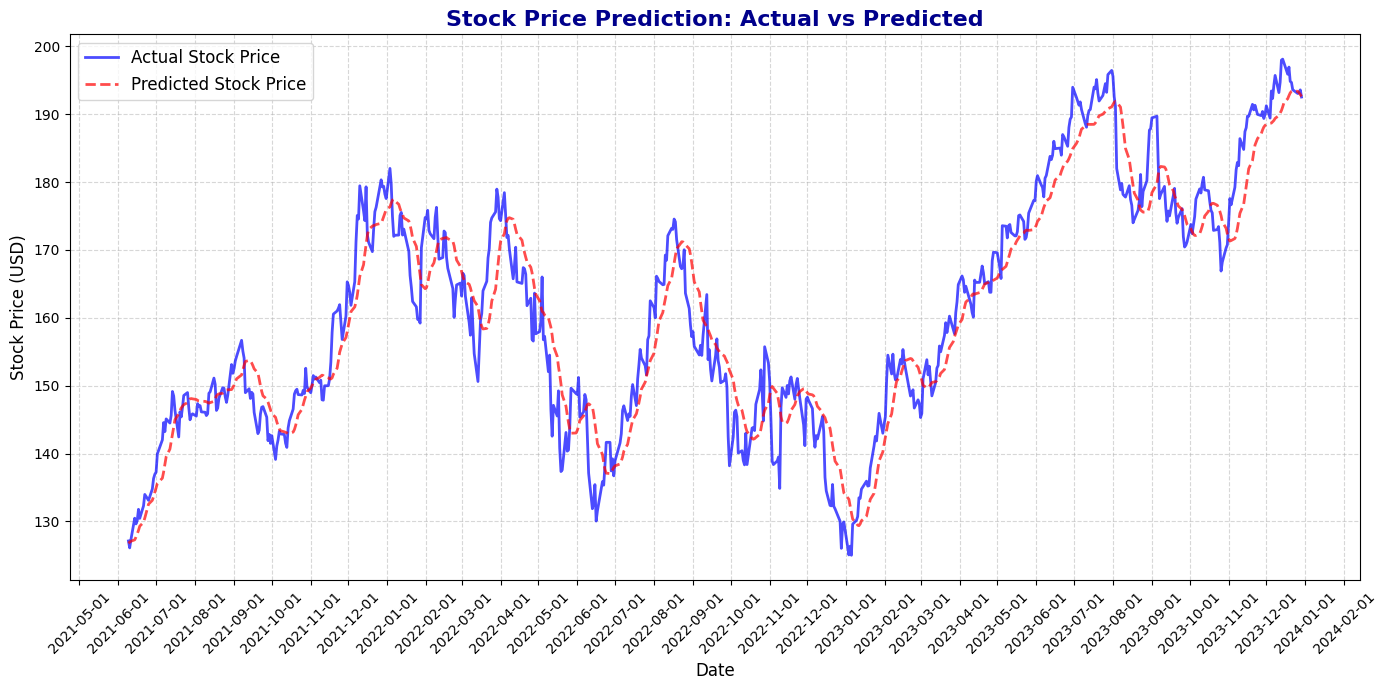

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Convert the dates (indices) to a date format for plotting
test_dates = stock_data.index[-len(y_test_actual):]  # Dates corresponding to the test set

# Create a figure and axis object
plt.figure(figsize=(14, 7))

# Plot the actual vs predicted stock prices
plt.plot(test_dates, y_test_actual, label='Actual Stock Price', color='blue', linewidth=2, linestyle='-', alpha=0.7)
plt.plot(test_dates, predictions, label='Predicted Stock Price', color='red', linewidth=2, linestyle='--', alpha=0.7)

# Adding title and labels
plt.title('Stock Price Prediction: Actual vs Predicted', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)

# Format the x-axis to show dates more clearly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format to YYYY-MM-DD
plt.gca().tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Add a legend to describe the lines
plt.legend(loc='upper left', fontsize=12)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()


## Unit Tests

In [ ]:
import unittest

class TestStockPrediction(unittest.TestCase):

    def test_data_download(self):
        """Test if stock data is downloaded correctly."""
        stock_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
        self.assertTrue(len(stock_data) > 0)

    def test_data_preprocessing(self):
        """Test if data preprocessing works correctly."""
        stock_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
        stock_data.fillna(method='ffill', inplace=True)
        data = stock_data[['Close']]
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)
        self.assertEqual(data_scaled.shape[0], stock_data.shape[0])

    def test_model_training(self):
        """Test if the LSTM model can be trained."""
        stock_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
        data = stock_data[['Close']].fillna(method='ffill')
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)

        # Prepare sequences
        train_size = int(len(data_scaled) * 0.8)
        train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]
        X_train, y_train = create_sequences(train_data)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

        # Build and compile the LSTM model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=1, batch_size=32)
        self.assertTrue(model.history.history['loss'])

    def test_model_prediction(self):
        """Test if predictions are being made."""
        stock_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
        data = stock_data[['Close']].fillna(method='ffill')
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)

        # Prepare sequences
        train_size = int(len(data_scaled) * 0.8)
        train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]
        X_test, y_test = create_sequences(test_data)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Build and compile the model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_test.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X_test, y_test, epochs=1, batch_size=32)

        # Predict stock prices
        predictions = model.predict(X_test)
        self.assertTrue(predictions.shape[0] > 0)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)  # This ensures that unittest doesn't call sys.exit()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_30/2454528469.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.2302
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_30/2454528469.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = stock_data[['Close']].fillna(method='ffill')
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0043


.
----------------------------------------------------------------------
Ran 4 tests in 12.630s

OK
